In [ ]:
# Install required packages
!pip install tensorflow numpy matplotlib pillow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from shutil import copy2

In [ ]:
# Path where all combined images are stored
combined_data_dir = "/content/drive/MyDrive/crop disease prediction/crop_images"

# Output directories
output_dir = "split_dataset"
os.makedirs(output_dir, exist_ok=True)

train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
test_dir = os.path.join(output_dir, "test")

# Split ratios (70% train, 15% val, 15% test)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Random seed for reproducibility
random_seed = 42

In [ ]:
# Get all image paths and their classes
image_paths = []
labels = []

for class_name in os.listdir(combined_data_dir):
    class_dir = os.path.join(combined_data_dir, class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            image_paths.append(img_path)
            labels.append(class_name)

# Convert to numpy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

# First split: train vs temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    image_paths, labels,
    test_size=(val_ratio + test_ratio),
    stratify=labels,
    random_state=random_seed
)

# Second split: val vs test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=(test_ratio / (val_ratio + test_ratio)),
    stratify=y_temp,
    random_state=random_seed
)

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Copy files to respective folders
def copy_files(paths, labels, target_dir):
    for img_path, class_name in zip(paths, labels):
        class_dir = os.path.join(target_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        copy2(img_path, class_dir)

copy_files(X_train, y_train, train_dir)
copy_files(X_val, y_val, val_dir)
copy_files(X_test, y_test, test_dir)

print(f"Train: {len(X_train)} images")
print(f"Val: {len(X_val)} images")
print(f"Test: {len(X_test)} images")

Train: 738 images
Val: 158 images
Test: 159 images


In [ ]:
from collections import Counter

def check_class_distribution(directory):
    generator = ImageDataGenerator().flow_from_directory(directory, class_mode='categorical', shuffle=False)
    return Counter(generator.classes)

print("Train distribution:", check_class_distribution(train_dir))
print("Val distribution:", check_class_distribution(val_dir))
print("Test distribution:", check_class_distribution(test_dir))

Found 738 images belonging to 5 classes.
Train distribution: Counter({4: 150, 0: 147, 1: 147, 2: 147, 3: 147})
Found 158 images belonging to 5 classes.
Val distribution: Counter({1: 32, 3: 32, 4: 32, 0: 31, 2: 31})
Found 159 images belonging to 5 classes.
Test distribution: Counter({4: 33, 0: 32, 2: 32, 1: 31, 3: 31})


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 5  # Based on your dataset
LEARNING_RATE = 0.0001
EPOCHS = 20

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
IMG_SIZE = (224, 224)  # or whatever your size is
BATCH_SIZE = 32

# Define ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0,
    width_shift_range=0.01,
    height_shift_range=0.001,
    shear_range=0.002,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Create Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,  # 👈 replace with your path
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',   # because your output is softmax (multi-class)
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,    # 👈 replace with your path
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,    # 👈 replace with your path
    target_size=IMG_SIZE,
    batch_size=1,             # usually batch_size=1 for testing
    class_mode='categorical',
    shuffle=False
)


Found 738 images belonging to 5 classes.
Found 158 images belonging to 5 classes.
Found 159 images belonging to 5 classes.


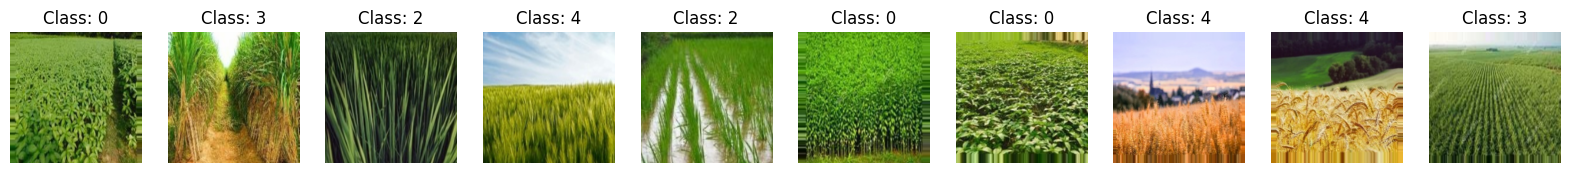

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of images and labels from the training generator
images, labels = next(train_generator)

# Number of images to display
num_images = 10

# Create a figure and subplots
fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

# Loop through the images and display them
for i in range(num_images):
    axes[i].imshow(images[i])
    axes[i].axis('off')
    axes[i].set_title(f"Class: {np.argmax(labels[i])}")  # Display the predicted class

# Show the plot
plt.show()


In [ ]:
from tensorflow.keras.layers import BatchNormalization

In [ ]:
# Load pre-trained MobileNetV2 without top layers
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze base model layers
base_model.trainable = False

# Add custom layers on top
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)  # <<-- Correct: pass inputs to base model
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)  # Additional layer
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

# Create final model
model = Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,048,517 (11.63 MB)

 Trainable params: 789,509 (3.01 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 733ms/step - accuracy: 0.2387 - loss: 2.3020 - val_accuracy: 0.3281 - val_loss: 1.6097
Epoch 2/20
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2500 - loss: 2.4645

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2500 - loss: 2.4645 - val_accuracy: 0.3359 - val_loss: 1.5979
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3466 - loss: 1.8121 - val_accuracy: 0.4766 - val_loss: 1.3457
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5625 - loss: 1.1905 - val_accuracy: 0.4844 - val_loss: 1.3354
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 402ms/step - accuracy: 0.4546 - loss: 1.3670 - val_accuracy: 0.5469 - val_loss: 1.1670
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6250 - loss: 1.1374 - val_accuracy: 0.5547 - val_loss: 1.1583
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 437ms/step - accuracy: 0.5696 - loss: 1.1543 - val_accuracy: 0.6875 - val_loss: 0.9969
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5625 - loss: 1.1769 - val_accuracy: 0.6875 - val_loss: 0.9899
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 432ms/step - accuracy: 0.6334 - loss: 0.9991 - val_accuracy: 0.7500 - val_loss

In [ ]:
# Unfreeze some layers for fine-tuning
base_model.trainable = True

# Let's unfreeze the top 50 layers
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE/10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS//2  # Typically fine-tune for fewer epochs
)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 965ms/step - accuracy: 0.5100 - loss: 1.3391 - val_accuracy: 0.8438 - val_loss: 0.5381
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3125 - loss: 1.8444 - val_accuracy: 0.8438 - val_loss: 0.5386
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 520ms/step - accuracy: 0.5173 - loss: 1.3268 - val_accuracy: 0.8359 - val_loss: 0.5318
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 1.4700 - val_accuracy: 0.8359 - val_loss: 0.5316
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 448ms/step - accuracy: 0.5549 - loss: 1.1635 - val_accuracy: 0.8281 - val_loss: 0.5265
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5938 - loss: 1.1300 - val_accuracy: 0.8281 - val_loss: 0.5259
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 450ms/step - accuracy: 0.5046 - loss: 1.3389 - val_accuracy: 0.8281 - val_loss: 0.5205
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 1.2495 - val_accuracy: 0.

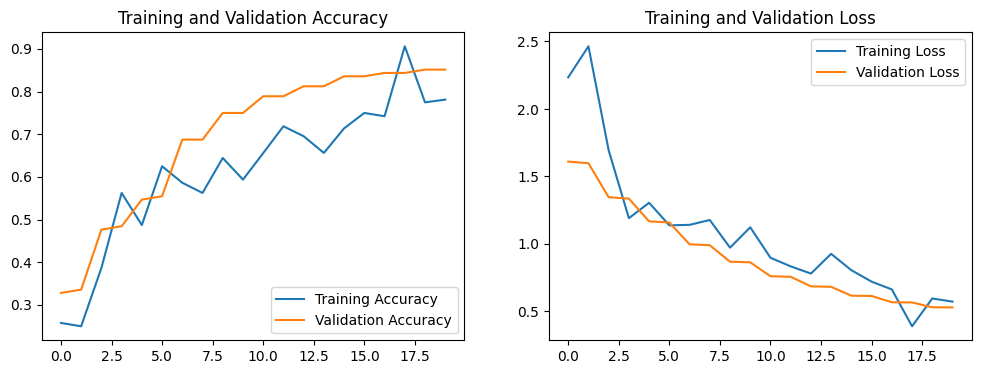

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)

In [ ]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')

159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9123 - loss: 0.3686
Test accuracy: 0.8742


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
test_generator.reset()
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)

# Get true labels
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
print(confusion_matrix(y_true, y_pred))

159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
              precision    recall  f1-score   support

        jute       0.88      0.94      0.91        32
       maize       0.93      0.81      0.86        31
        rice       0.79      0.94      0.86        32
   sugarcane       0.92      0.74      0.82        31
       wheat       0.89      0.94      0.91        33

    accuracy                           0.87       159
   macro avg       0.88      0.87      0.87       159
weighted avg       0.88      0.87      0.87       159

[[30  1  1  0  0]
 [ 4 25  0  1  1]
 [ 0  0 30  0  2]
 [ 0  1  6 23  1]
 [ 0  0  1  1 31]]


In [ ]:
model.save('/content/drive/MyDrive/crop_disease_model.h5')

In [ ]:
model.save('/content/drive/MyDrive/crop_disease_model.keras')

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    pred = model.predict(img_array)
    predicted_class = class_names[np.argmax(pred)]
    confidence = np.max(pred)

    return predicted_class, confidence

# Example usage
img_path = '/content/drive/MyDrive/crop disease prediction/test_crop_image/wheat-field01.jpg'
class_name, confidence = predict_image(img_path)
print(f'Predicted: {class_name} with confidence {confidence:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted: rice with confidence 0.68
